In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.losses import SparseCategoricalCrossentropy


In [2]:
BATCH_SIZE = 8
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2178 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [5]:
len(class_names)

2

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(8, 128, 128, 3)
[0 1 1 1 0 0 1 1]


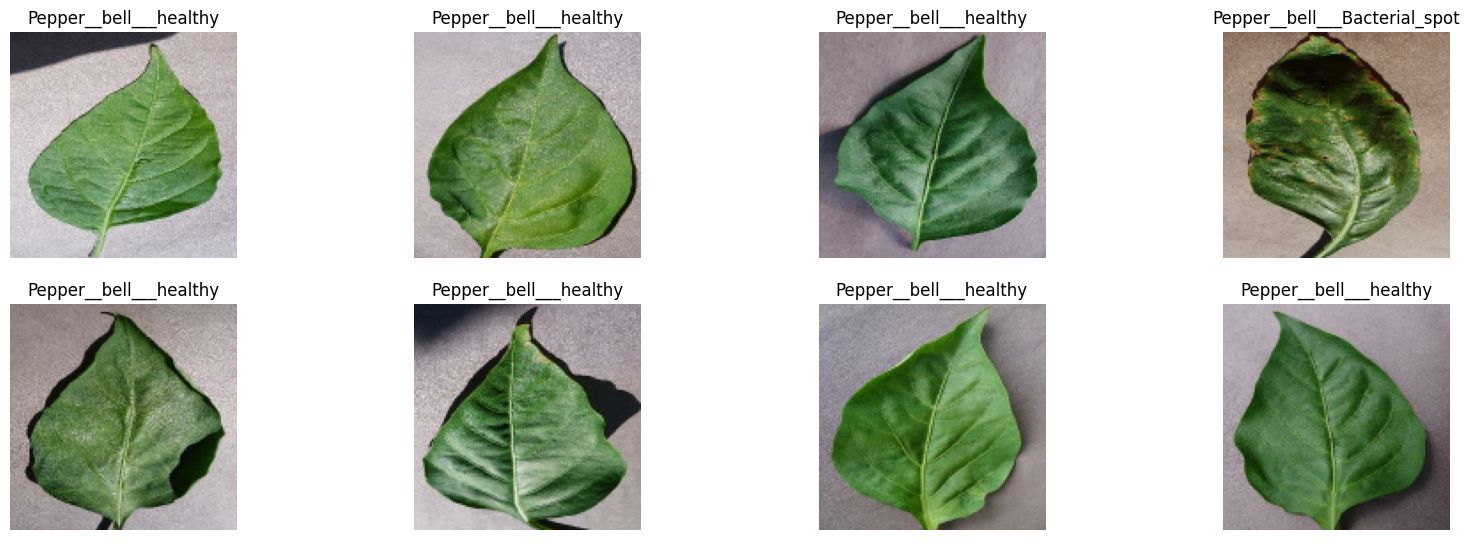

In [7]:
plt.figure(figsize=(20, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

273

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

218

In [12]:
len(val_ds)

27

Prefetch the Dataset


In [13]:
train_ds = train_ds.prefetch(1)
val_ds   = val_ds.prefetch(1)
test_ds  = test_ds.prefetch(1)


Building the Model


In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [15]:
n_classes = 15

model = models.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  
    layers.Rescaling(1./255), 

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(), 

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),    
    
    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, padding="same", activation="relu"),
    layers.GlobalAveragePooling2D(), # it wrok as flaten

    layers.Dense(n_classes, activation="softmax"),
])


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,271 (1.50 MB)

 Trainable params: 392,271 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [17]:
model.compile(
    optimizer='adam',
    loss=SparseCategoricalCrossentropy(),  
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.7468 - loss: 0.5426 - val_accuracy: 0.8056 - val_loss: 0.4185
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.8682 - loss: 0.3367 - val_accuracy: 0.9259 - val_loss: 0.2002
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.9068 - loss: 0.2411 - val_accuracy: 0.9630 - val_loss: 0.1992
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.9114 - loss: 0.3011 - val_accuracy: 0.9537 - val_loss: 0.1859
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.9323 - loss: 0.1862 - val_accuracy: 0.9537 - val_loss: 0.2321
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9373 - loss: 0.2528 - val_accuracy: 0.9120 - val_loss: 0.2899
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9505 - loss: 0.1910 - val_accuracy: 0.9905 - val_loss: 0.0743
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9730 - loss: 0.0852 - 

In [19]:
scores = model.evaluate(test_ds)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 9.1917e-05


In [20]:
scores

[9.191703429678455e-05, 1.0]

Plotting the Accuracy and Loss Curves


In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

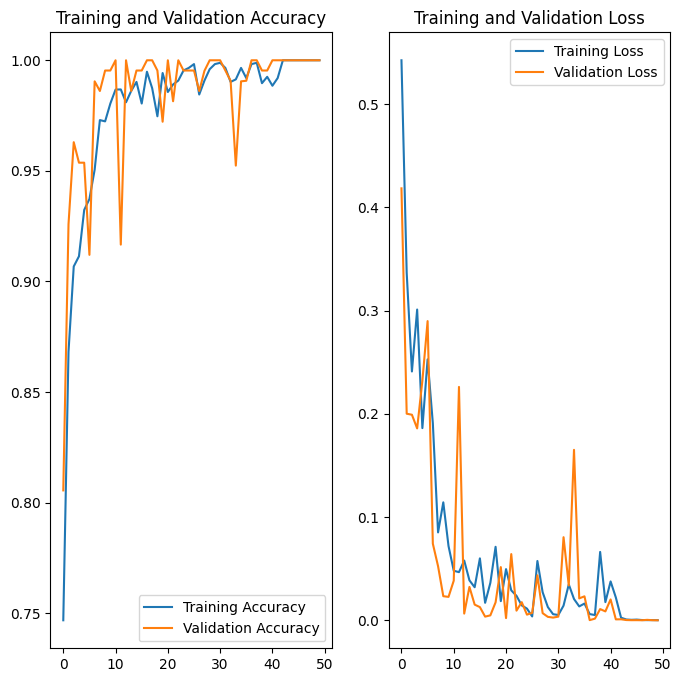

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image


first image to predict
actual label: Pepper__bell___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
predicted label: Pepper__bell___healthy


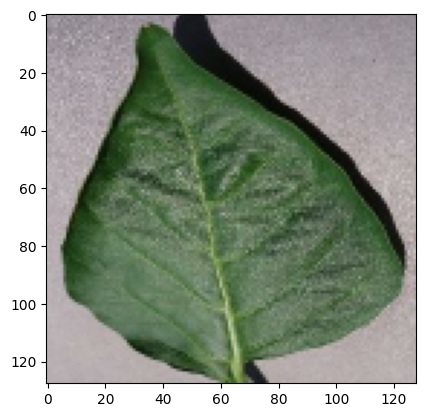

In [23]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)

    return predicted_class, confidence


In [25]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [26]:
import os
save_dir = "../models"
os.makedirs(save_dir, exist_ok=True)
existing = [
    int(f.split(".")[0]) 
    for f in os.listdir(save_dir) 
    if f.endswith(".keras") and f.split(".")[0].isdigit()
]
model_version = max(existing + [0]) + 1
model.save(f"{save_dir}/{model_version}.keras")
print(f"Model saved at version {model_version}")


Model saved at version 1
